In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from ODE.FirstOrder.FirstOrderODEEulerMethod import FirstOrderODEEulerMethod
from ODE.FirstOrder.FirstOrderODEHeunMethod import FirstOrderODEHeunMethod
from StopConditions.StopAtPlateau import StopAtPlateau
from IPython.display import clear_output

import numpy as np

In [2]:
def bungee_jumper_velocity(m, cd, t, g=9.8):
    return np.sqrt(g * m / cd) * np.tanh(np.sqrt(g*cd/m) * t)

def bungee_jumper_acceleration(m, cd, v, g=9.8):
    return g - (cd * v ** 2 /m)

if __name__ == '__main__':
    m  = 68.1 # kg
    cd = 0.25 # kg/m
    v0 = 0    # m/s
    dt = 2    # s
    
    a = lambda x,t: bungee_jumper_acceleration(m, cd, x)

# Solve Analytically

$$ \frac{dv}{dt} = g - \frac{C_d v^2}{m} $$
$$ v(t) = \sqrt{\frac{m g}{C_d}} \tanh{(\sqrt{\frac{g C_d}{m}} t)}  $$


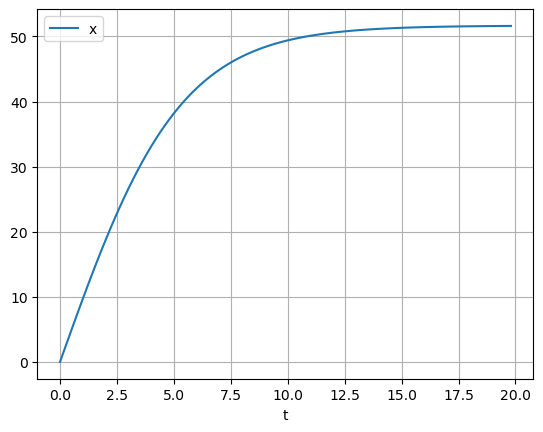

In [3]:
analytical_df = pd.DataFrame(
    data=dict(
        t=np.arange(0, 20, dt/10)
    )
)
analytical_df['x'] = bungee_jumper_velocity(m, cd, analytical_df['t'])
analytical_df.plot(x='t', y='x', linestyle='-')
plt.grid()

# Euler Method
$$ \frac{dx}{dt} = f(x,t) $$
$$ x_{n+1} = x_{n} - \Delta t * f(x,t) $$

In [4]:
euler_solver = FirstOrderODEEulerMethod(
    derivative_function=a, t0=0, x0=v0, dt=dt)
euler_solver_df = euler_solver.run()
clear_output()

2025-03-03 09:15:36,451 - FirstOrderODEEulerMethod - INFO - Numerical.py:run:102 - Starting FirstOrderODEEulerMethod
2025-03-03 09:15:36,452 - FirstOrderODEEulerMethod - INFO - Numerical.py:initialize:48 - Initial state:{'x': 0, 't': 0, 'dt': 2, 'dx_dt': 9.8}
2025-03-03 09:15:36,453 - FirstOrderODEEulerMethod - INFO - Numerical.py:run:107 - Iteration 1 completed
Stop condition [StopIfGreaterThan] not met: Variable t is less than 20
Stop condition [StopIfNaN      ] not met: No NaN values found
2025-03-03 09:15:36,453 - FirstOrderODEEulerMethod - INFO - Numerical.py:run:112 - State: 
{'x': 19.6, 't': 2, 'dt': 2, 'dx_dt': 9.8}

2025-03-03 09:15:36,454 - FirstOrderODEEulerMethod - INFO - Numerical.py:run:107 - Iteration 2 completed
Stop condition [StopIfGreaterThan] not met: Variable t is less than 20
Stop condition [StopIfNaN      ] not met: No NaN values found
2025-03-03 09:15:36,455 - FirstOrderODEEulerMethod - INFO - Numerical.py:run:112 - State: 
{'x': 36.37944199706314, 't': 4, 'dt':

,x,t,dt,dx_dt
0,0.000000,0,2,9.800000
1,19.600000,2,2,9.800000
2,36.379442,4,2,8.389721
3,46.262380,6,2,4.941469
4,50.148666,8,2,1.943143
5,51.283991,10,2,0.567662
6,51.573802,12,2,0.144905
7,51.644749,14,2,0.035473
8,51.661929,16,2,0.008590
9,51.666078,18,2,0.002075


In [ ]:
euler_solver_df

# Henus Method

$$ x_{predicted} = x_n + \Delta t \times f(x,t) $$


ValueError: Variable 'x' not found in history. Available variables: ['x_c', 'x_p', 't', 'dt', 'dx_dt']

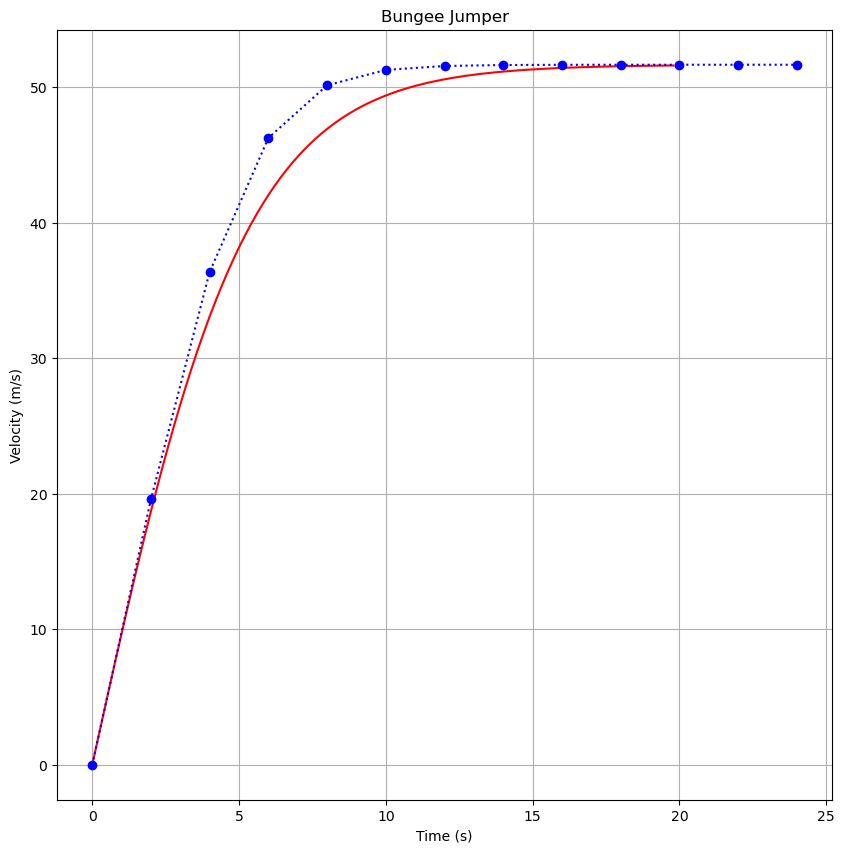

In [6]:
heun_solver = FirstOrderODEHeunMethod(
    derivative_function=a, t0=0, x0=v0, dt=dt,
    stop_conditions=[StopAtPlateau(tracking='x', patience=2)]
)
heun_solver_df = heun_solver.run()
clear_output()
heun_solver_df

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.grid()
ax.set_title('Bungee Jumper')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Velocity (m/s)')

ax.plot(analytical_df['t'], analytical_df['x'], color='red', label='Analytical solution')

euler_solver.plot_history(x_var='t', y_var='x', ax=ax, color='blue',
                    label='Euler method', linestyle=':', marker='o')

heun_solver.plot_history(x_var='t', y_var='x', ax=ax, color='green',
                     label='Heun method', linestyle=':', marker='o')

ax.legend()
ax.set_xlim(0, 20)

,x_c,x_p,t,dt,dx_dt
0,0.0,0,0,2,9.8


In [ ]:
euler_solver_df